# Data Analysis of the generated images and residuals without outliers

In this notebook, we generate the dataset with lenstronomy. The aim is to show the data used for the neural network and confirm if the generated data fits our expectations with simulated images.
As we deal with an absolute error on the residuals, we test some error percentage to ensure that the error is difficult to see with the naked eye. 
Finally, we check the distribution of variable and labels to ensure that our dataset building is correct.

The final configuration for the simulated images:
Lens' mass variation :
- Model: Power-law Elliptical Mass Distribution

>$\kappa = \frac{3-\gamma }{2}\left ( \frac{\theta_E}{\sqrt{q e_1^2+ e_2^2/q}} \right )^{\gamma-1}$
 
* Einstein radius: $\theta_E \in \mathcal{N}_{log}(\mu:0,\sigma:0.1)$

* Power law slope: $\gamma \in \mathcal{N}_{log}(\mu:0.7,\sigma:0.1)$
* Ellipsity* : $e_1 \in \mathcal{N}(\mu :0, \sigma : 0.2)$   and $e_2 \in \mathcal{N}(\mu :0, \sigma : 0.2)$
* Center : $x = 0$ and $y = 0$

Source variation :
* Model : Sersic ellipse
* Amplitude : $amp \in  \mathcal{U}(20, 24)$
* Sersic radius : $R_{sersic} \in  \mathcal{N}_{log}(\mu:-0.7,\sigma:0.4)$
* Sersic index : $n_{sersic} \in  \mathcal{N}_{log}(\mu:0.7,\sigma:0.4)$
* Ellipsity* : $e_1 \in \mathcal{U}(\mu :0, \sigma : 0.2)$   and $e_2 \in \mathcal{U}(\mu :0, \sigma : 0.2)$
* Center : $x \in \mathcal{U}(-0.5,0.5)$ and $y \in \mathcal{U}(-0.5,0.5)$

Note* : The ellipsity range is determined and is approximated with the following equations, where $q \in \mathcal{U}(0.7, 1)$ and $\phi \in \mathcal{U}(0, \frac{\pi}{2})$

>$e_1 = \frac{1-q}{1+q}\cos{(2\phi)}$     and     $e_2 = \frac{1-q}{1+q}\sin{(2\phi)} $
    
The added error is proportionally defined such that each quantity is defined as follows:

>$A_err = A \pm p A$

Where $A$ is the current quantity value and $p$ the user-defined percentage of error. 

The final data configuration parameters :
* Size of the whole dataset: $s = 6000$
* Ratio of error maps: $r = 75\%$
* Percentage of error : $p = \begin{bmatrix}5\% & 1.5\% & 5\%\end{bmatrix}$

We do not consider outliers in this data set: noise-like error residual maps and maps with a maximal absolute amplitude superior to $6$. The bound to remove the noise-like data in computing the Peak Signal-to-Noise Ratio (PSNR) between a map that does not contain any noise and any errors and compares it to the mean PSNR of maps only include noise. If the values are lower, we automatically discard the image. Otherwise, we keep the value.

Chi-square measure for noise like maps:
>$\chi^2 = \frac{1}{NM}\sum_{n= 0}^N \sum_{m=0}^M \left[ I_1(n,m) - I_2(n,m)\right]^2$

Where $I_1$ is the imaging data, $I_2$ is the model, $n$ the line in the image and $m$ the column.

Absolute measure for obvious error maps:
>$|g (n,m)|<6$ for every pixel in the residual map $g$



### 0. Import

In [1]:
import numpy as np
import pandas as pd
from statistics import mean
from scipy.stats import chi2, chi, gaussian_kde

from helpers.data_generation.file_management import read_hdf5
from helpers.data_generation.error_generation_chi2 import Residual, CombineDataset, LensDataset

%matplotlib inline
import matplotlib.pyplot as plt
from matplotlib import colors
import seaborn as sns
sns.set(style="whitegrid")

import warnings
warnings.filterwarnings("ignore")

### 1. Build the data set
The residual maps are generated and stored in the repository `data/dataset/` under the name `S[size]R[ratio]_lens.h5`, while the metadata is saved under the name `S[size]R[ratio]_meta.h5`. The `[size]` corresponds to the number of images, and the `[ratio]` is the percentage of error.

In [2]:
# Build the four classes 
size = 6000; ratio = 0.75;
percent = np.array([0.005, 0.015, 0.005])
res = Residual()
res.build(size, ratio = ratio, per_error = percent)

print('Data Generation Finished')

Data Generation Finished


In [3]:
str_ID =  "S"+str(size)+"R"+str(int(ratio*100))
[final_array, metadata] = read_hdf5(str_ID)

print('Reading data Finished')

index = metadata.index

indices_noerror = index[[col == [0,0] for col in metadata['class']]]
indices_mass = index[[col == [1,0] for col in metadata['class']]]
indices_source = index[[col == [0,1] for col in metadata['class']]]
indices_masssource = index[[col == [1,1] for col in metadata['class']]]

Reading data Finished


## 2. Plot the residual maps and simulated images
#### Residual maps
We observe in the residual plot that maps that are noise-like and with obvious errors are no more present in the final dataset.

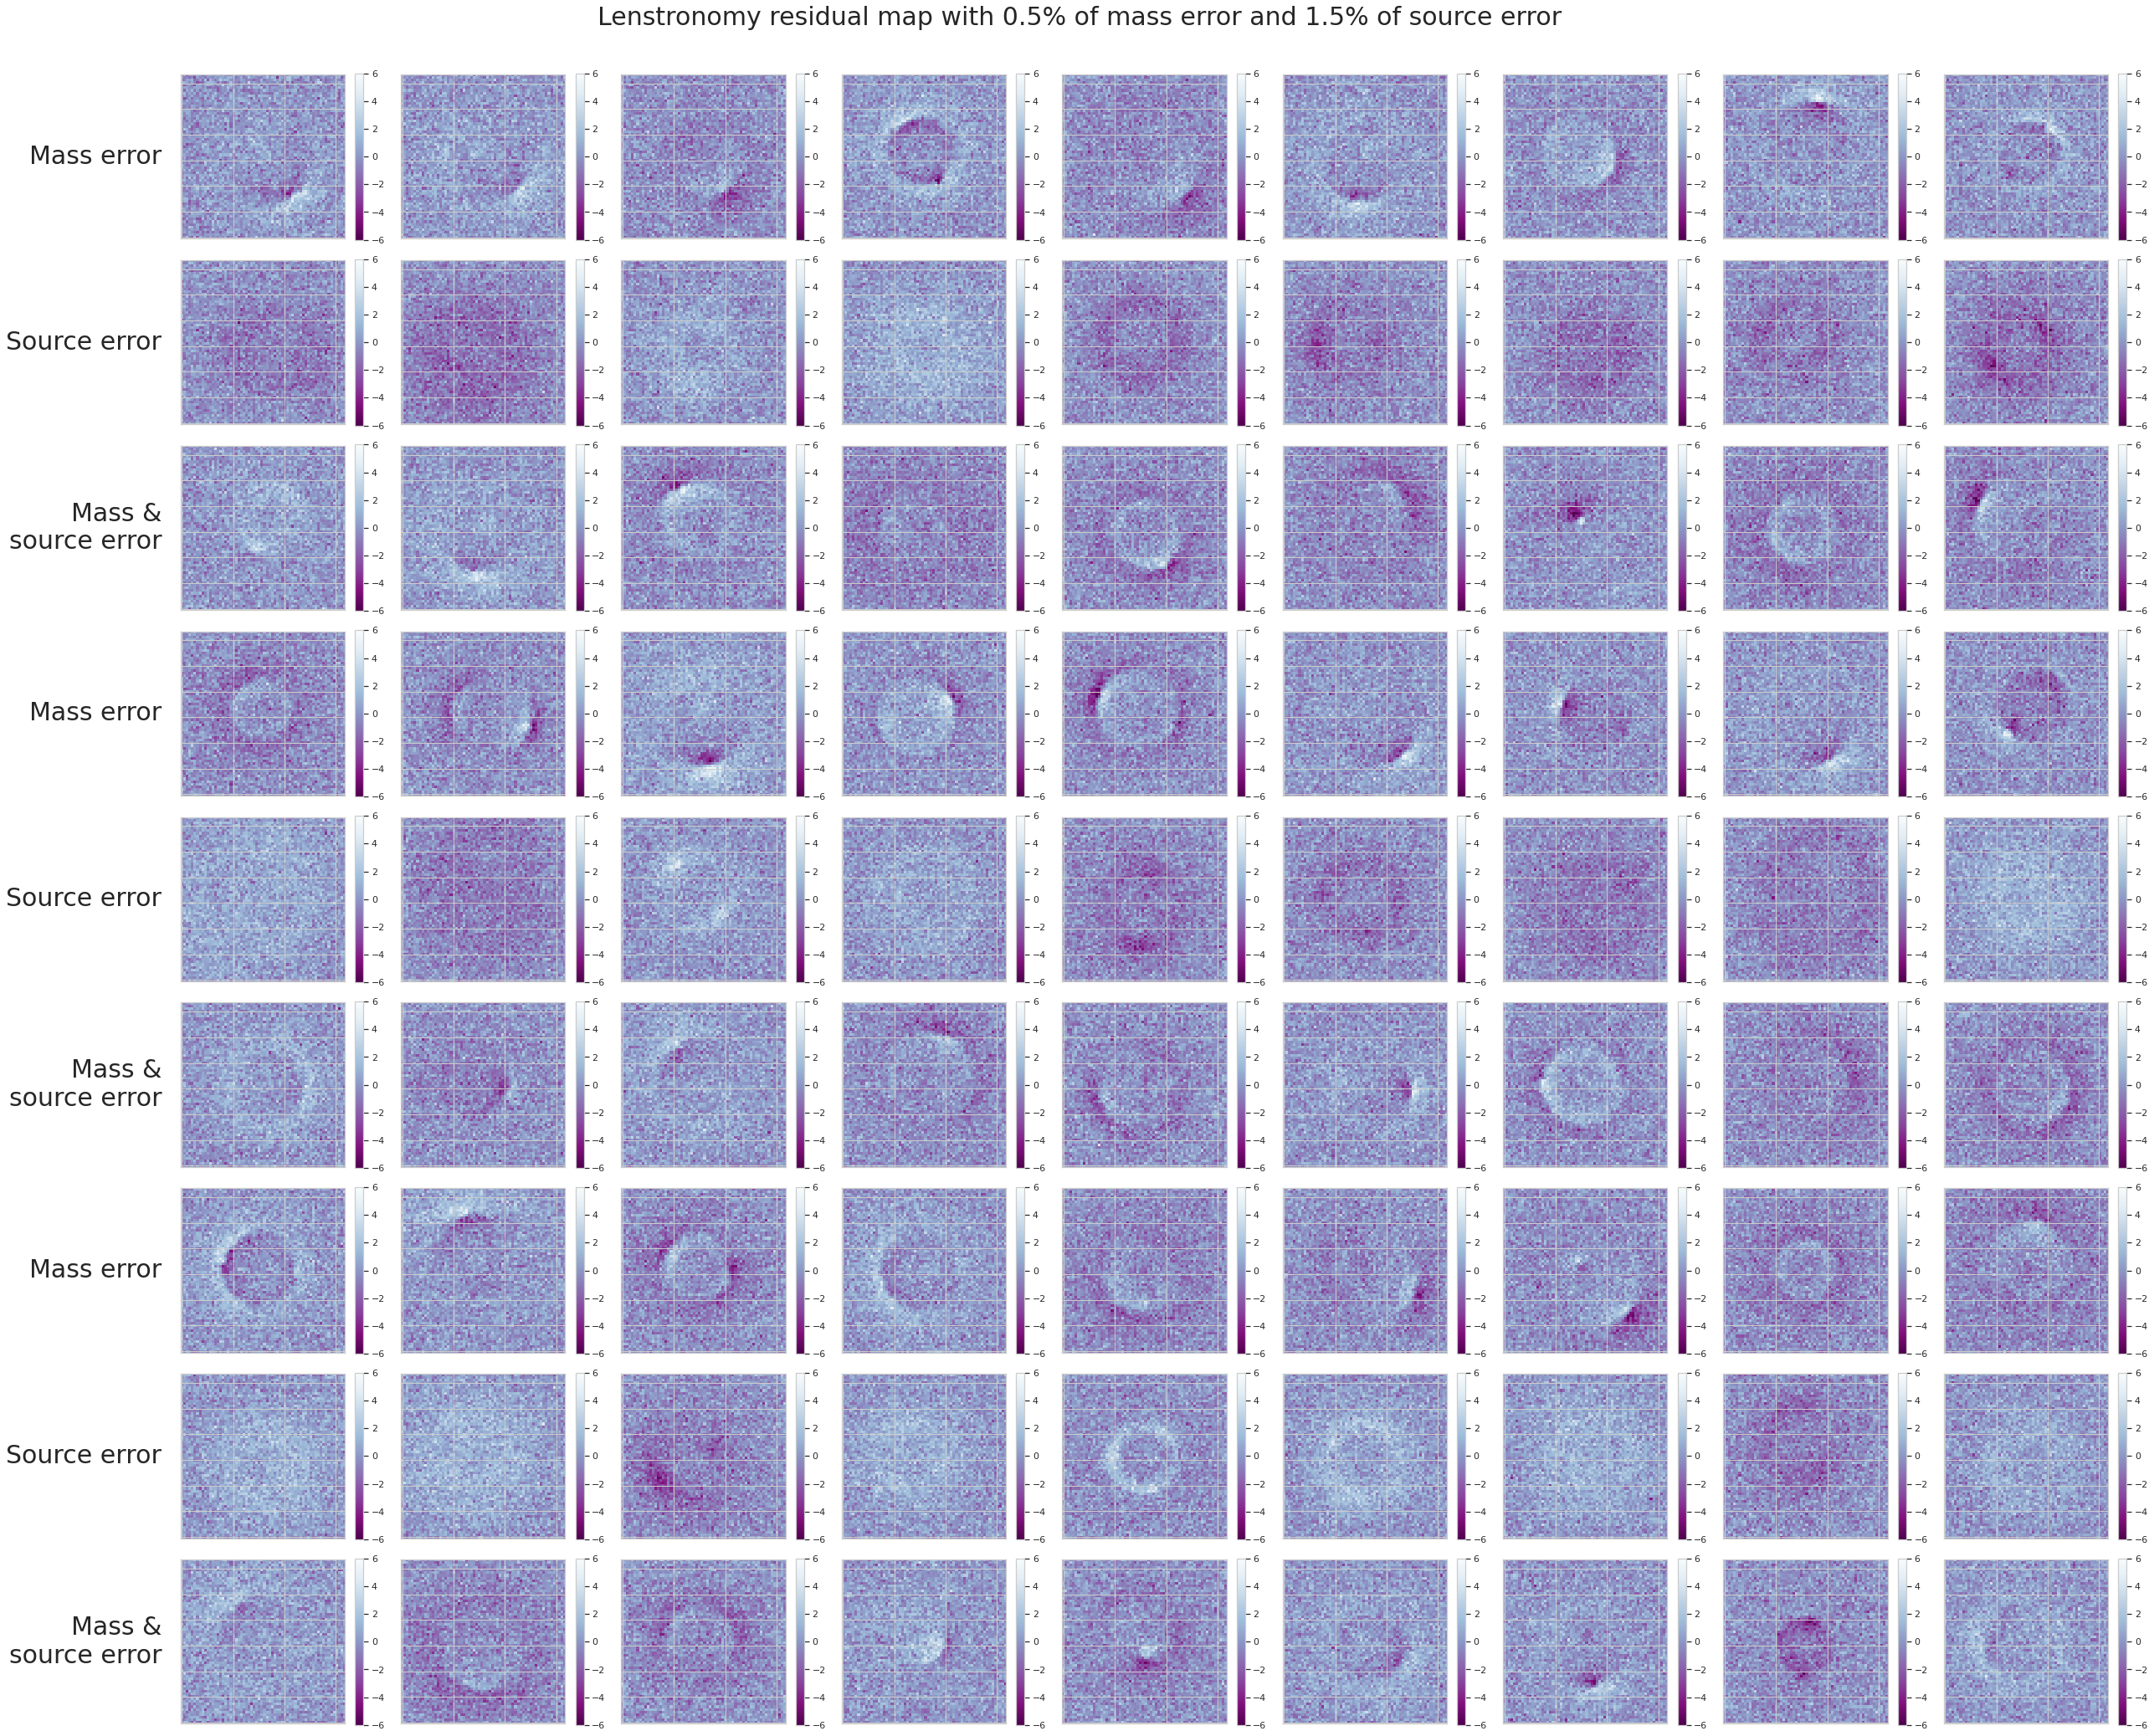

In [4]:
f, axes = plt.subplots(9, 9, figsize=(36, 30), sharex=False, sharey=False)

for count, k in enumerate(np.array([0, 3, 6])):
    for i in range(0,9):
        pos1 = axes[k,i].imshow(final_array[indices_mass[i+9*count],0,:,:], vmin=-6, vmax=6, origin='lower',cmap=plt.cm.BuPu_r)
        pos2 = axes[k+1,i].imshow(final_array[indices_source[i+9*count],0,:,:], vmin=-6, vmax=6, origin='lower',cmap=plt.cm.BuPu_r)
        pos3 = axes[k+2,i].imshow(final_array[indices_masssource[i+9*count],0,:,:], vmin=-6, vmax=6, origin='lower',cmap=plt.cm.BuPu_r)

        axes[k,i].set_yticklabels([]); axes[k,i].set_xticklabels([])
        axes[k+1,i].set_yticklabels([]); axes[k+1,i].set_xticklabels([])
        axes[k+2,i].set_yticklabels([]); axes[k+2,i].set_xticklabels([])
        f.colorbar(pos1, ax=axes[k,i]); f.colorbar(pos2, ax=axes[k+1,i])
        f.colorbar(pos3, ax=axes[k+2,i])
    
    
    pad = 5
    font = 30

    axes[k,0].annotate('Mass error', xy=(0, 0.5), xytext=(-axes[k,0].yaxis.labelpad - pad, 0),
                       xycoords=axes[k,0].yaxis.label, textcoords='offset points', ha='right', va='center',fontsize=font)
    axes[k+1,0].annotate('Source error', xy=(0, 0.5), xytext=(-axes[k+1,0].yaxis.labelpad - pad, 0),
                       xycoords=axes[k+1,0].yaxis.label, textcoords='offset points', ha='right', va='center',fontsize=font)
    axes[k+2,0].annotate('Mass &\nsource error', xy=(0, 0.5), xytext=(-axes[k+2,0].yaxis.labelpad - pad, 0),
                       xycoords=axes[k+2,0].yaxis.label, textcoords='offset points', ha='right', va='center',fontsize=font)
    
f.suptitle('Lenstronomy residual map with {:.1f}% of mass error and {:.1f}% of source error'.format(percent[0]*100, percent[1]*100), size = 'large',fontsize=font)
plt.tight_layout(rect=[0, 0.02, 1, 0.97])
plt.show()

plt.show()
f.savefig('figures/datanalysis/'+str(int(percent[0]*100))+'percenterror_chi2.jpeg')

#### Auto-correlation of the previously showed residual maps

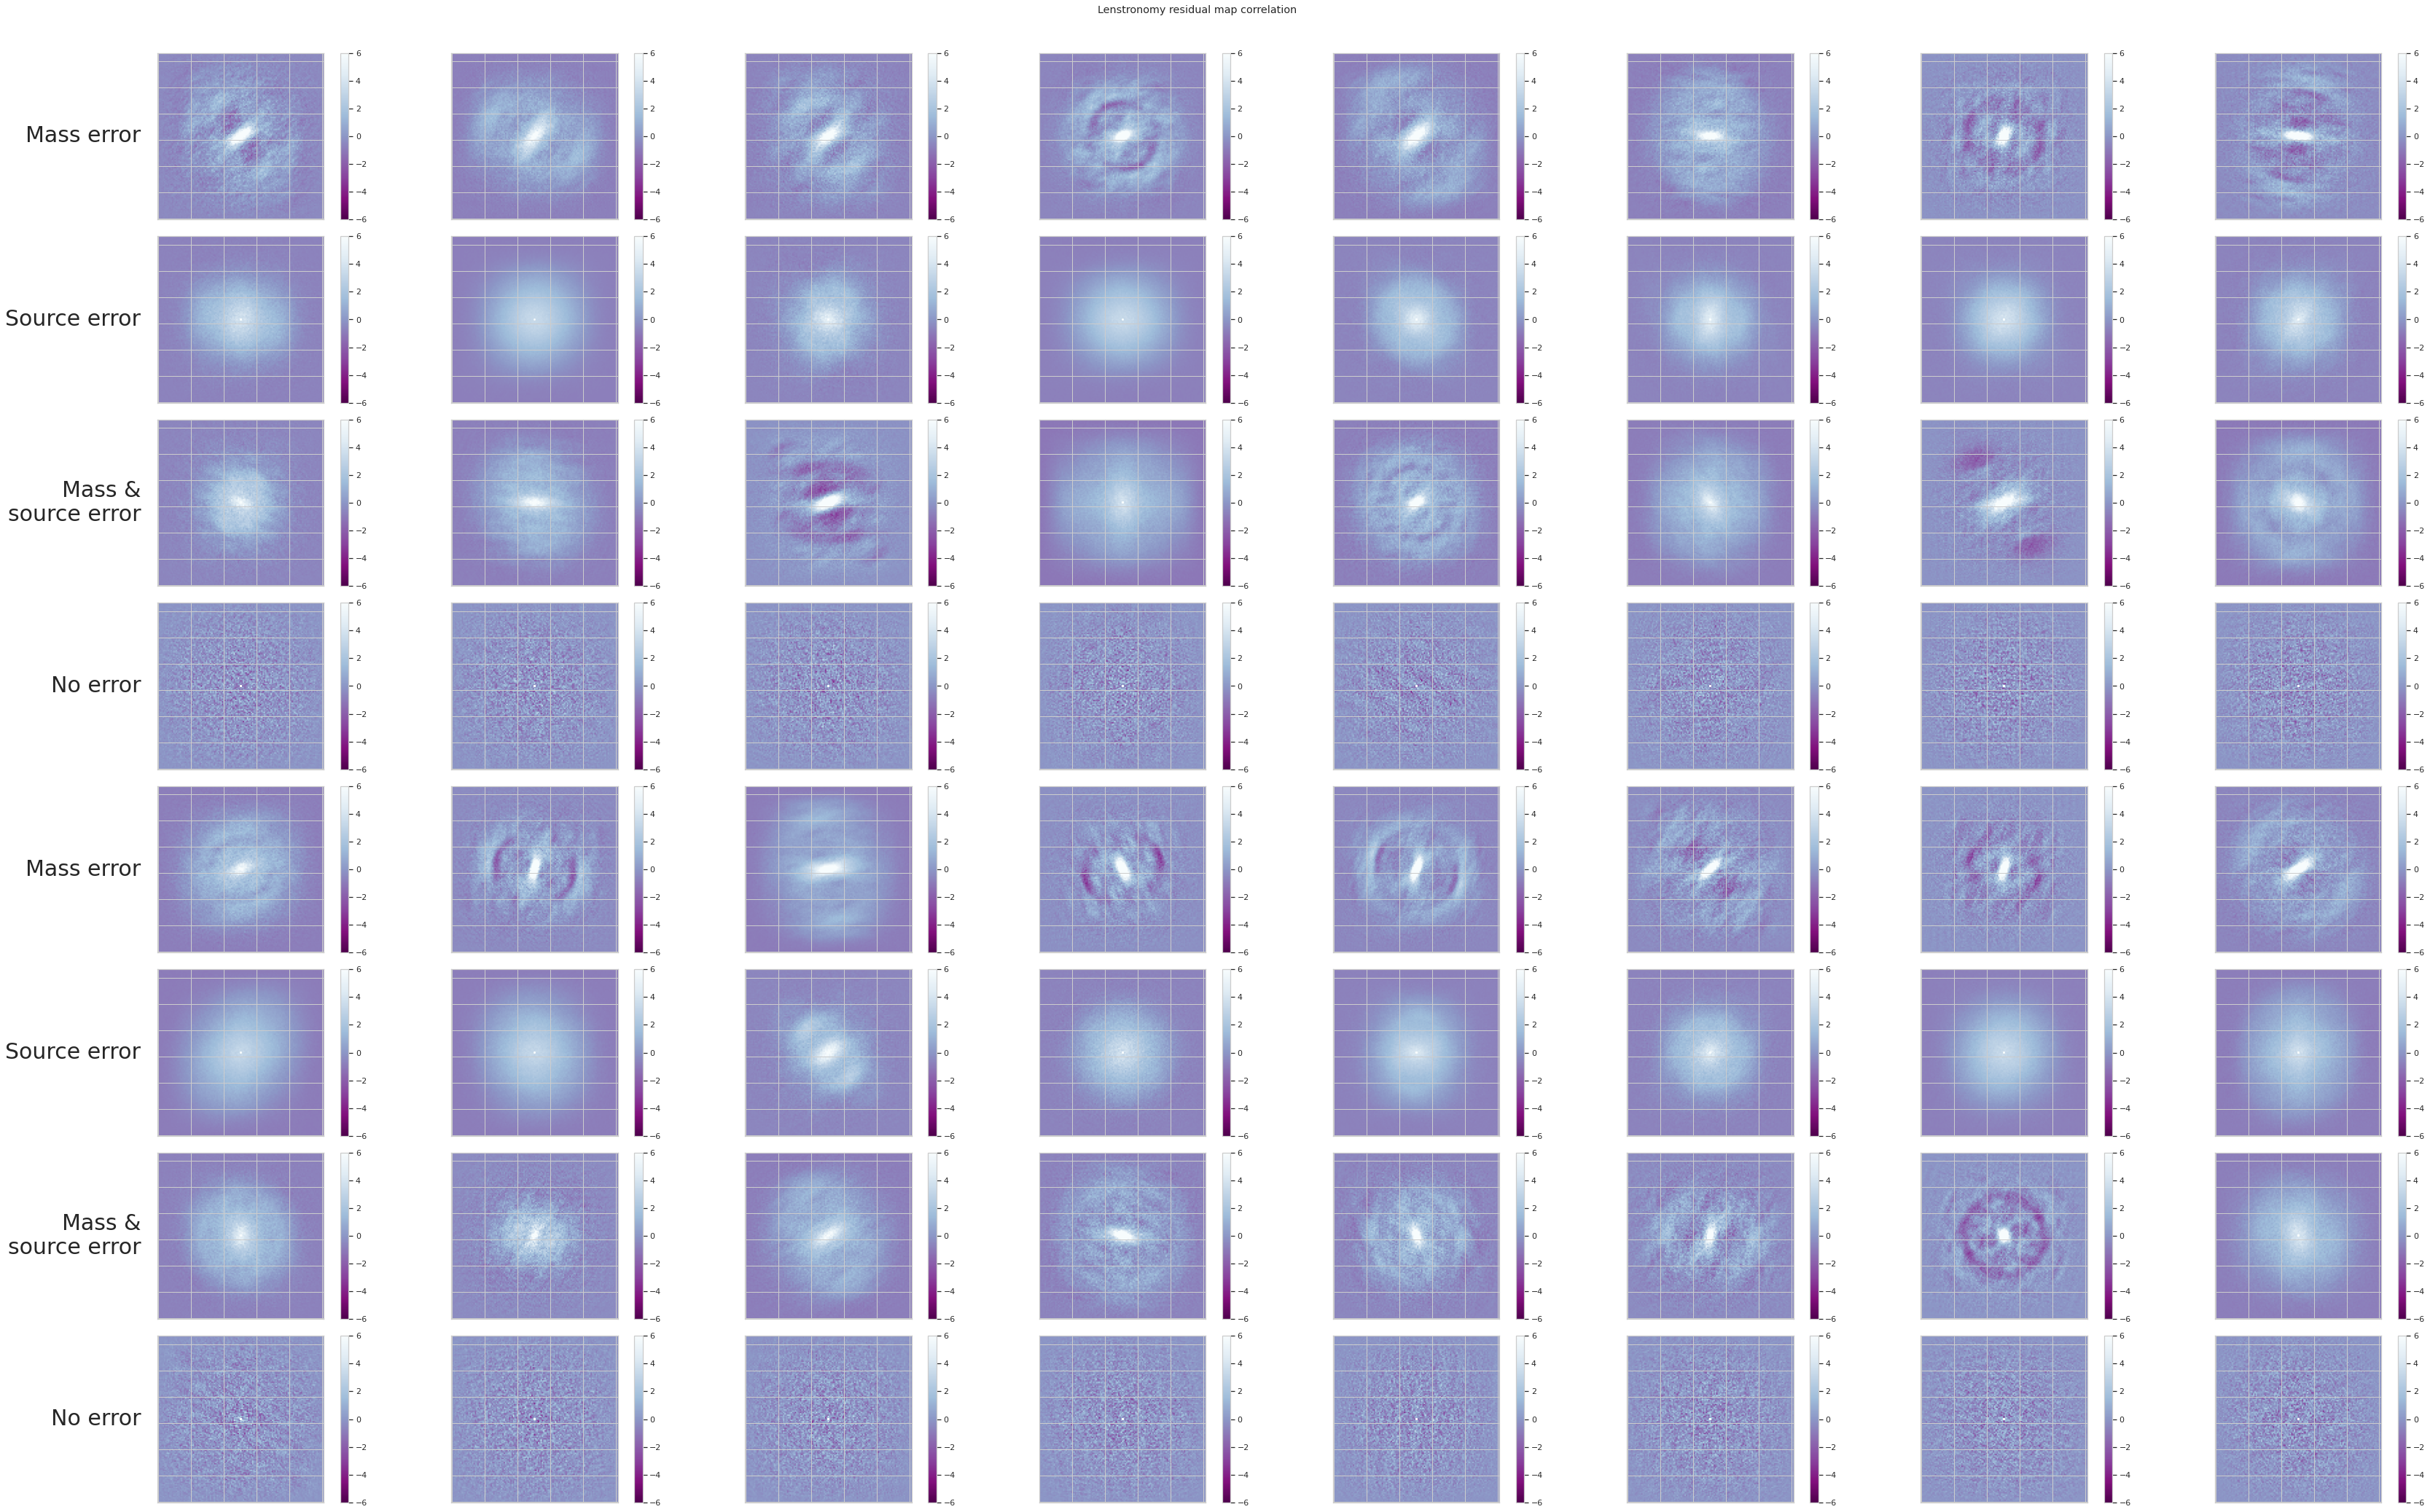

In [5]:
from scipy import signal
cor = signal.correlate2d (final_array[indices_mass[0],0,:,:], final_array[indices_mass[0],0,:,:])

f, axes = plt.subplots(8, 8, figsize=(48, 30), sharex=False, sharey=False)
ran = 6
for count, k in enumerate(np.array([0, 4,])):
    for i in range(0,8):
        cor_mass = signal.correlate2d (final_array[indices_mass[i+9*count],0,:,:], final_array[indices_mass[i+9*count],0,:,:])
        cor_source = signal.correlate2d (final_array[indices_source[i+9*count],0,:,:], final_array[indices_source[i+9*count],0,:,:])
        cor_sourcemass = signal.correlate2d (final_array[indices_masssource[i+9*count],0,:,:], final_array[indices_masssource[i+9*count],0,:,:])
        cor_noerror = signal.correlate2d (final_array[indices_noerror[i+9*count],0,:,:], final_array[indices_noerror[i+9*count],0,:,:])
        cor_mass = (cor_mass- np.mean(cor_mass))/np.std(cor_mass)
        cor_source = (cor_source- np.mean(cor_source))/np.std(cor_source)
        cor_sourcemass = (cor_sourcemass- np.mean(cor_sourcemass))/np.std(cor_sourcemass)
        cor_noerror = (cor_noerror- np.mean(cor_noerror))/np.std(cor_noerror)
        pos1 = axes[k,i].imshow(cor_mass,  vmin=-ran, vmax=ran, origin='lower',cmap=plt.cm.BuPu_r)
        pos2 = axes[k+1,i].imshow(cor_source,  vmin=-ran, vmax=ran, origin='lower',cmap=plt.cm.BuPu_r)
        pos3 = axes[k+2,i].imshow(cor_sourcemass, vmin=-ran, vmax=ran, origin='lower',cmap=plt.cm.BuPu_r)
        pos4 = axes[k+3,i].imshow(cor_noerror, vmin=-ran, vmax=ran, origin='lower',cmap=plt.cm.BuPu_r)

        axes[k,i].set_yticklabels([]); axes[k,i].set_xticklabels([])
        axes[k+1,i].set_yticklabels([]); axes[k+1,i].set_xticklabels([])
        axes[k+2,i].set_yticklabels([]); axes[k+2,i].set_xticklabels([])
        axes[k+3,i].set_yticklabels([]); axes[k+3,i].set_xticklabels([])
        f.colorbar(pos1, ax=axes[k,i]); f.colorbar(pos2, ax=axes[k+1,i]); f.colorbar(pos3, ax=axes[k+2,i]); f.colorbar(pos4, ax=axes[k+3,i])
    
    
    pad = 5
    font = 30

    axes[k,0].annotate('Mass error', xy=(0, 0.5), xytext=(-axes[k,0].yaxis.labelpad - pad, 0),
                       xycoords=axes[k,0].yaxis.label, textcoords='offset points', ha='right', va='center',fontsize=font)
    axes[k+1,0].annotate('Source error', xy=(0, 0.5), xytext=(-axes[k+1,0].yaxis.labelpad - pad, 0),
                       xycoords=axes[k+1,0].yaxis.label, textcoords='offset points', ha='right', va='center',fontsize=font)
    axes[k+2,0].annotate('Mass &\nsource error', xy=(0, 0.5), xytext=(-axes[k+2,0].yaxis.labelpad - pad, 0),
                       xycoords=axes[k+2,0].yaxis.label, textcoords='offset points', ha='right', va='center',fontsize=font)
    
    axes[k+3,0].annotate('No error', xy=(0, 0.5), xytext=(-axes[k+3,0].yaxis.labelpad - pad, 0),
                       xycoords=axes[k+3,0].yaxis.label, textcoords='offset points', ha='right', va='center',fontsize=font)
f.suptitle('Lenstronomy residual map correlation', size = 'large')
plt.tight_layout(rect=[0, 0.02, 1, 0.97])
plt.show()

#### Residual maps without error

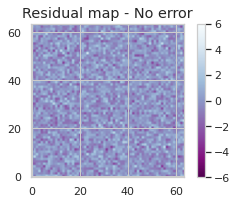

In [6]:
f, axes = plt.subplots(1, 1, figsize=(4, 3), sharex=False, sharey=False)
index = metadata.index

indices_noerror = index[[col == [0,0] for col in metadata['class']]]

pos = plt.imshow(final_array[indices_noerror[0],0,:,:], vmin=-6, vmax=6, origin='lower',cmap=plt.cm.BuPu_r)


plt.colorbar(pos);

plt.title('Residual map - No error', size = 'large')
plt.tight_layout()
plt.show()
f.savefig('figures/datanalysis/Noerror.png')

#### Simulated images 

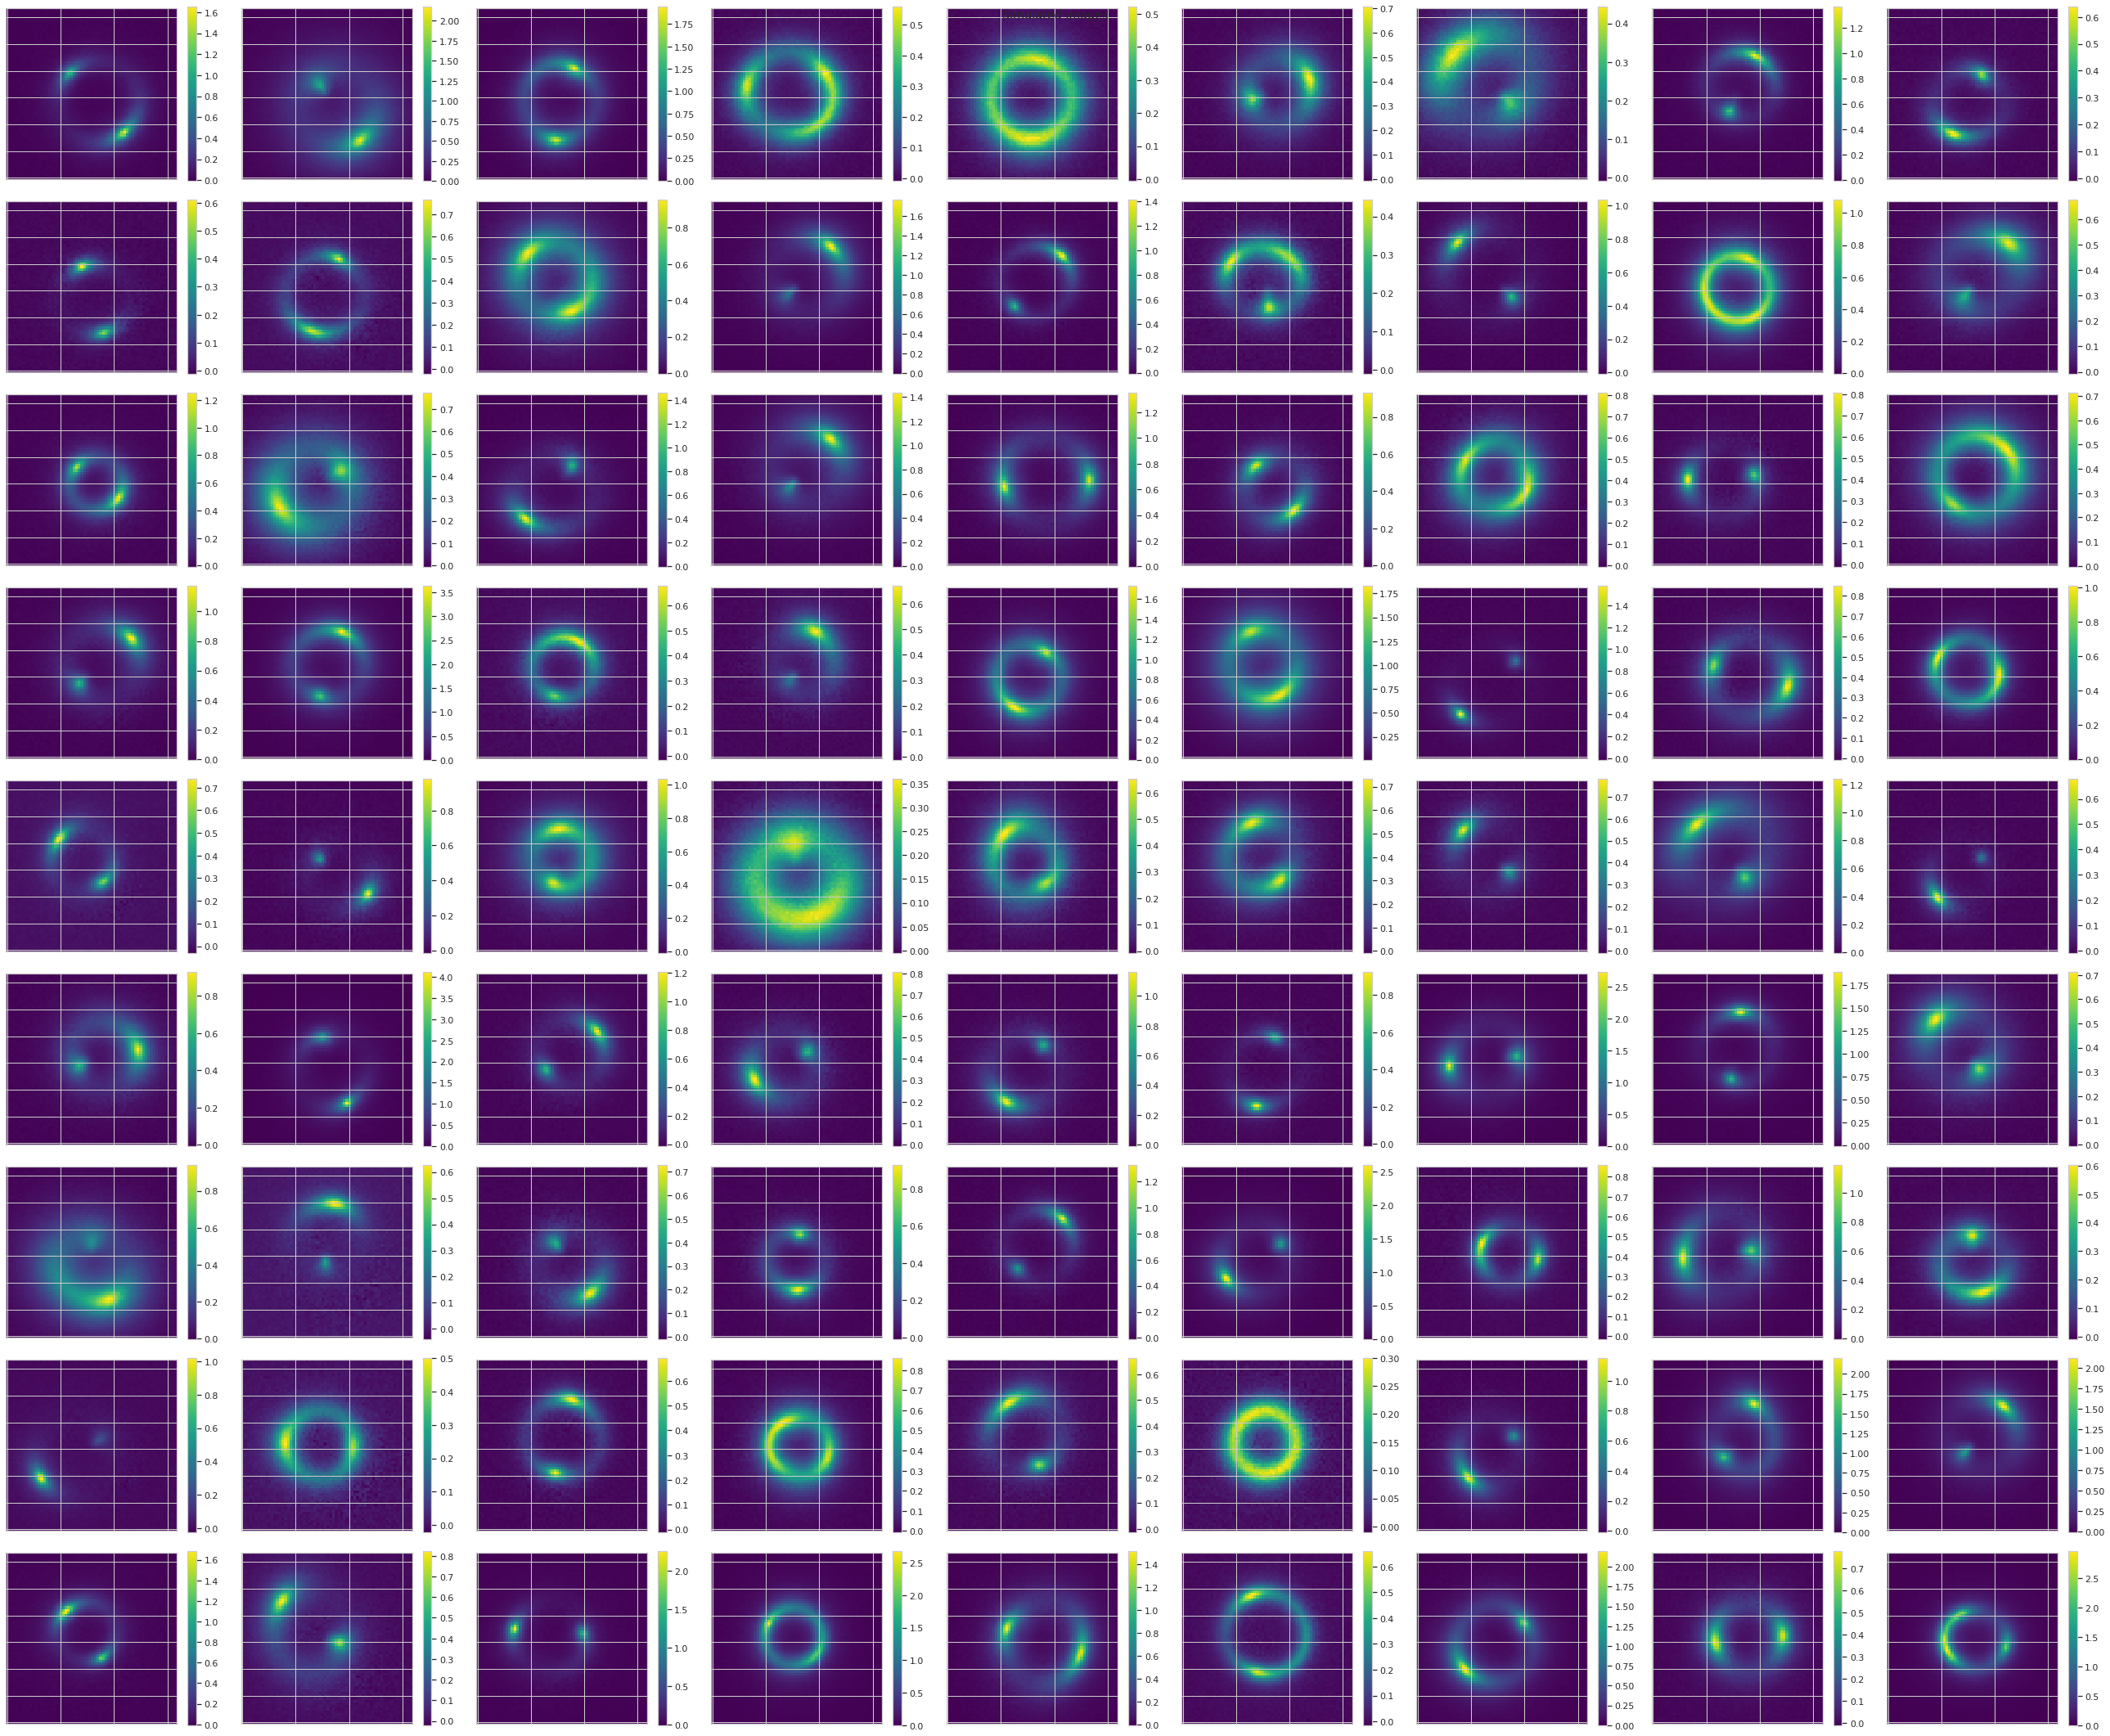

In [7]:
f, axes = plt.subplots(9, 9, figsize=(36, 30), sharex=False, sharey=False)
dataset_model = LensDataset(size = size, percent = percent)
p_decal = 10

for i in range(0,9):
    for k in range(9):
        
        image_real = dataset_model.images[i+k*p_decal][0] + dataset_model.image_config.noise_for_model(model = dataset_model.images[i][0])
        pos1 = axes[k,i].imshow(image_real, cmap = 'viridis', origin='lower')
        axes[k,i].set_yticklabels([]); axes[k,i].set_xticklabels([])
        f.colorbar(pos1, ax=axes[k,i])

f.suptitle('Simulated images', size = 'large')
f.tight_layout()
plt.show()

## 3. Distribution of the Chi2 test
#### Chi square 

The Chi-square test is similar to the distance approach, yet instead of comparing with an image with no error that is noisy, the data is compared with a residual that is noiseless.

Chi2 mean of the mass : 1.2799626117515503
Chi2 mean of the source : 1.488809266343006
Chi2 mean of the mass & the source : 1.3137488806876285
Chi2 mean of no error : 0.9996288846820046


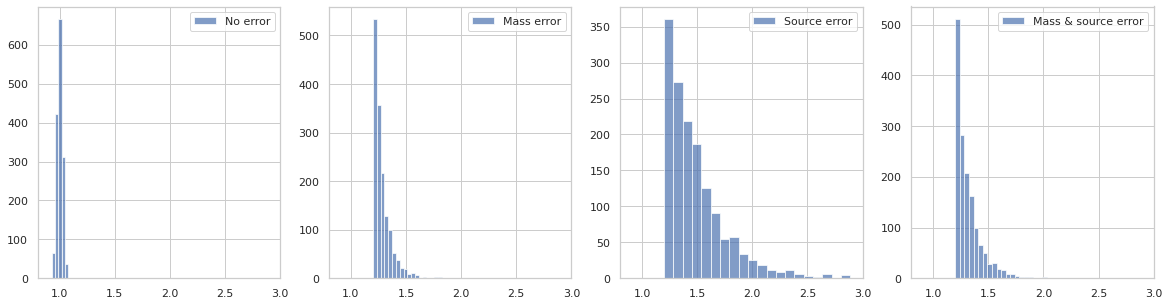

In [11]:
from scipy.stats import chi2, chi

ki2_noerror = [np.sum(final_array[i,0,:,:]**2)/(final_array.shape[3]*final_array.shape[2])for i in indices_noerror]
ki2_mass = [np.sum(final_array[i,0,:,:]**2)/(final_array.shape[3]*final_array.shape[2])for i in indices_mass]
ki2_source = [np.sum(final_array[i,0,:,:]**2)/(final_array.shape[3]*final_array.shape[2])for i in indices_source]
ki2_masssource = [np.sum(final_array[i,0,:,:]**2)/(final_array.shape[3]*final_array.shape[2])for i in indices_masssource]

print('Chi2 mean of the mass : '+ str(mean(ki2_mass))+ '\nChi2 mean of the source : ' + str(mean(ki2_source))+ 
      '\nChi2 mean of the mass & the source : ' +  str(mean(ki2_masssource))+ '\nChi2 mean of no error : ' + str(mean(ki2_noerror)))
f, axes = plt.subplots(1, 4, figsize=(20, 5), sharex=False, sharey=False)

axes[0].hist(ki2_noerror, label = 'No error', bins = 5, alpha=0.7)
axes[1].hist(ki2_mass, label = 'Mass error', bins = 20, alpha=0.7)
axes[2].hist(ki2_source, label = 'Source error',bins = 20, alpha=0.7)
axes[3].hist(ki2_masssource, label = 'Mass & source error', bins = 20, alpha=0.7)
plt.setp(axes, xlim=(0.8, 3))
axes[0].legend()
axes[1].legend()
axes[2].legend()
axes[3].legend()
f.savefig('figures/datanalysis/Chi2final_chi2.png')
f.show()